# Complete re-run 06/20/2024, 30% CV luminex, 50% CV functionals (rpm4, w Xin updates); QC index error corrected

In [1]:
library(nlme)
library(performance)
library(dplyr)
library(ggplot2)
# library(plyr)
library(ggpubr)
source('decay.functions.r')
# set colors 
col = c('Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD')
library(rstatix)


Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter




In [2]:
data_m = read.csv('../data-final/DS2-annotated_luminex.lum_func.melted.csv',stringsAsFactors = F)
data_r = read.csv('../data-final/DS2-annotated_luminex.lum_func.melted.raw.csv',stringsAsFactors = F)
# data_m = read.csv('../data-final/DS2-annotated_luminex.no_norm.melted.csv',stringsAsFactors = F)
data_decay_params=read.csv('../data-final/DS04-data_decay.rand_intercepts.just_model.csv',row.names=1) 


In [3]:
# remove neut
data_m = data_m %>% filter( affinity!='NeutIC50') %>% droplevels()
data_r = data_r %>% filter( affinity!='NeutIC50') %>% droplevels()
data_decay_params = data_decay_params %>% filter( affinity!='NeutIC50') %>% droplevels()
unique(data_decay_params$affinity)

[1] "C1q"     "IgA1"    "IgG1"    "IgG2"    "IgG3"    "IgG4"    "IgM"    
 [8] "R2a"     "R2b"     "R3av"    "R3b"     "ADCPBL3" "ADNP"

In [4]:

# data_m$group = factor(as.character(data_m$group),levels = c('o','p','C'))
# data_m$virus = factor(as.character(data_m$virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43'))
# data_r$virus = factor(as.character(data_r$virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43'))
#data_m$virus = relevel( factor(as.character(data_m$virus)) , ref = 'WT' )

data_m = merge(data_m,data_r,suffixes = c('','_raw'),by=colnames(data_m)[colnames(data_m)!='value'])
data_m$virus = factor(as.character(data_m$virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43'))
data_m$vaccine = gsub('-.*','',data_m$vaccine)
head(data_m)
# head(data_r)
str(data_m)
data_i = data_m


,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,group,BOX,Lab.ID,Vaccine,...,DPFD,DPSD,DPTD,order,variable,antigen,virus,affinity,value,value_raw
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>
1,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.C1q,RBD,Alpha,C1q,1.2205047,2497.00
2,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgA1,RBD,Alpha,IgA1,0.6345194,4574.25
3,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG1,RBD,Alpha,IgG1,0.6033457,10216.00
4,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG2,RBD,Alpha,IgG2,0.2067241,3182.00
5,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG3,RBD,Alpha,IgG3,0.6672060,2886.50
6,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG4,RBD,Alpha,IgG4,0.9876875,2667.25


'data.frame':	122670 obs. of  22 variables:
 $ PlateNum   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SampleNum  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ PlateID    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ PlateCoord : chr  "A1" "A1" "A1" "A1" ...
 $ ID         : chr  "Naive" "Naive" "Naive" "Naive" ...
 $ vaccine    : chr  "Naive" "Naive" "Naive" "Naive" ...
 $ group      : chr  "C" "C" "C" "C" ...
 $ BOX        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Lab.ID     : chr  "C64 2020 G4" "C64 2020 G4" "C64 2020 G4" "C64 2020 G4" ...
 $ Vaccine    : chr  "Naive" "Naive" "Naive" "Naive" ...
 $ Tube.Label : chr  "S_PUC_C_064_(1)_G4" "S_PUC_C_064_(1)_G4" "S_PUC_C_064_(1)_G4" "S_PUC_C_064_(1)_G4" ...
 $ Time.sample: chr  "PRE" "PRE" "PRE" "PRE" ...
 $ DPFD       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ DPSD       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ DPTD       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ order      : num  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 ...
 $ variable   : chr  "Alpha.RBD.C1q" "Alpha.RBD.Ig

In [5]:
all_data<-reshape2::dcast(Lab.ID+DPFD+DPSD+DPTD+ID+vaccine ~ affinity+antigen+virus,
                     data=data_m[!is.na(data_m$antigen)&!is.na(data_m$virus),],value.var = 'value',fun.aggregate = mean)
all_data$DPFD = ifelse(is.na(all_data$DPFD),0,all_data$DPFD)

rownames(all_data) = paste( all_data$Lab.ID , all_data$vaccine, all_data$DPFD , sep='_')

all_data$vaccine = factor(as.character(all_data$vaccine),levels = c('Naive','Hosp','Out','Pfizer','CoronaVac','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))


all_data$DPFD = with(all_data,
                     ifelse( !is.na(DPTD) , DPTD ,
                       ifelse( !is.na(DPSD) , DPSD ,
                              ifelse( !is.na(DPFD) , DPFD , 0
                                     ))))

all_data = all_data %>% arrange(vaccine,DPFD) %>% rename(DPI=DPFD)

all_data = all_data[ !is.na(all_data$vaccine) , !grepl('C1q|HKU1|OC43',colnames(all_data)) & grepl('Spike|RBD|ID|^DP|vaccine',colnames(all_data))]

head(all_data)

,Lab.ID,DPI,DPSD,DPTD,ID,vaccine,ADCPBL3_Spike_WT,ADCPBL3_Spike_Omicron,ADNP_Spike_WT,ADNP_Spike_Omicron,...,R3b_RBD_Beta,R3b_RBD_Delta,R3b_RBD_Gamma,R3b_RBD_Omicron,R3b_Spike_WT,R3b_Spike_Alpha,R3b_Spike_Beta,R3b_Spike_Delta,R3b_Spike_Gamma,R3b_Spike_Omicron
,<chr>,<dbl>,<int>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C64 2020 G4_Naive_0,C64 2020 G4,0,NA,NA,Naive,Naive,1.0824565,1.7674821,0.5090898,1.0439637,...,1.1992201,1.0309028,0.9915017,1.3648657,1.0058406,1.1093193,1.0189958,1.040095,1.2034646,1.0333011
C94 2021 G4_Naive_0,C94 2021 G4,0,NA,NA,Naive,Naive,1.1073560,1.3568407,0.9026673,1.4289804,...,0.9077701,1.0488187,1.0040419,0.5078688,0.9838090,0.9881175,0.9525711,1.027064,1.0000000,0.9790659
C97 2021 G4_Naive_0,C97 2021 G4,0,NA,NA,Naive,Naive,1.2120249,0.9881156,0.8801256,0.9282630,...,0.9603857,1.0144735,0.9467302,0.7525499,0.9828478,1.0000000,1.0018149,0.982413,0.9348791,0.9772696
C75 2021 G4_Naive_0,C75 2021 G4,0,NA,NA,Naive,Naive,1.0077273,1.5855676,0.9638637,0.9713377,...,1.1372994,0.9888906,1.0250803,1.1990746,1.0082803,1.0610253,1.0099214,1.017223,1.1334763,1.0189305
C99 2021 G4_Naive_0,C99 2021 G4,0,NA,NA,Naive,Naive,0.9038386,0.7498597,0.9758054,0.9311485,...,1.3483354,2.7532468,1.9537776,0.7908838,1.0574449,0.9870141,0.9962492,1.001731,0.9829028,0.9964074
C76 2021 G4_Naive_0,C76 2021 G4,0,NA,NA,Naive,Naive,0.9887894,0.8560741,1.2150020,0.9799034,...,1.0610636,1.1706306,1.1227070,1.0559355,0.9769333,1.0121372,1.0000000,1.018225,1.0383714,1.0225922


In [6]:

vi=viridis::viridis(6)
names(vi) = c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron')

colors=list(
    vaccine = c('Naive'='white',
        'Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD',
           'HospCoronaVac'='#8B1888','OutCoronaVac'='#E79188',
           'HospPfizer'='#8B18FF','OutPfizer'='#E791FF'),
    antigen=c('RBD'='blue','Spike'='red'),
    virus=vi
    )

In [7]:
dev.off()

null device 
          1

In [8]:
head(data_i)
dim(data_i)
colnames(data_decay_params)
dim( data_exp<-unique( merge(data_i,data_decay_params[,c('variable','antigen','virus','affinity','naive_2.5','naive_50','naive_97.5','naive_50_raw','naive_97.5_raw','naive_se')],all.x = T)))
head(data_decay_params)
head(data_exp)

,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,group,BOX,Lab.ID,Vaccine,...,DPFD,DPSD,DPTD,order,variable,antigen,virus,affinity,value,value_raw
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>
1,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.C1q,RBD,Alpha,C1q,1.2205047,2497.00
2,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgA1,RBD,Alpha,IgA1,0.6345194,4574.25
3,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG1,RBD,Alpha,IgG1,0.6033457,10216.00
4,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG2,RBD,Alpha,IgG2,0.2067241,3182.00
5,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG3,RBD,Alpha,IgG3,0.6672060,2886.50
6,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG4,RBD,Alpha,IgG4,0.9876875,2667.25


[1] 122670     22

[1] "vaccine"        "variable"       "antigen"        "virus"         
 [5] "affinity"       "model_type"     "n"              "hl"            
 [9] "hl_se"          "hl_t"           "I"              "I_se"          
[13] "I_t"            "Pr_t_I"         "Pr_t_hl"        "naive_2.5"     
[17] "naive_50"       "naive_97.5"     "naive_50_raw"   "naive_97.5_raw"
[21] "naive_se"

[1] 122670     28

,vaccine,variable,antigen,virus,affinity,model_type,n,hl,hl_se,hl_t,...,I_se,I_t,Pr_t_I,Pr_t_hl,naive_2.5,naive_50,naive_97.5,naive_50_raw,naive_97.5_raw,naive_se
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CoronaVac,Alpha.RBD.C1q,RBD,Alpha,C1q,lm,56,-0.0006143962,0.0003778246,-1.6261414,...,0.03347245,3.932596,0.0002415242,0.10974203,0.8514664,1,1.266710,2045.875,2591.531,231.7655
2,CoronaVac,Beta.RBD.C1q,RBD,Beta,C1q,lm,26,-0.0021294641,0.0010758594,-1.9793145,...,0.10114949,1.324682,0.1977525589,0.05936241,0.5184145,1,2.221973,28432.750,63176.800,15660.9760
3,CoronaVac,Delta.RBD.C1q,RBD,Delta,C1q,lm,56,-0.0005481919,0.0003786758,-1.4476548,...,0.03343946,3.283467,0.0018025685,0.15349477,0.8664983,1,1.226207,2227.500,2731.375,235.9695
4,CoronaVac,Gamma.RBD.C1q,RBD,Gamma,C1q,lm,52,-0.0005682394,0.0004135541,-1.3740390,...,0.03743789,1.162840,0.2504142590,0.17555816,0.5884511,1,1.376384,3883.500,5345.188,900.5460
5,CoronaVac,Omicron.RBD.C1q,RBD,Omicron,C1q,lm,47,0.0005809210,0.0007403875,0.7846174,...,0.06738418,-3.688259,0.0006060414,0.43678906,0.5941412,1,1.404198,545335.250,765758.594,133732.5325
6,CoronaVac,WT.RBD.C1q,RBD,WT,C1q,lm,54,-0.0008508566,0.0008010399,-1.0621900,...,0.06917320,3.116501,0.0029783152,0.29305770,0.9023562,1,1.250513,1716.250,2146.194,170.5627


,variable,antigen,virus,affinity,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,...,DPTD,order,value,value_raw,naive_2.5,naive_50,naive_97.5,naive_50_raw,naive_97.5_raw,naive_se
,<chr>,<chr>,<fct>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alpha.RBD.C1q,RBD,Alpha,C1q,3,171,3,A3,CoronaVac2,CoronaVac,...,NA,341.5,1.3418464,2745.25,0.8514664,1,1.26671,2045.875,2591.531,231.7655
5,Alpha.RBD.C1q,RBD,Alpha,C1q,64,484,6,F4,Out-3,Out,...,NA,967.5,1.2125529,2936.50,0.8514664,1,1.26671,2045.875,2591.531,231.7655
9,Alpha.RBD.C1q,RBD,Alpha,C1q,14,266,4,B2,Hosp-1,Hosp,...,NA,531.5,1.0502736,2543.50,0.8514664,1,1.26671,2045.875,2591.531,231.7655
13,Alpha.RBD.C1q,RBD,Alpha,C1q,35,119,2,C11,CoronaVac,CoronaVac,...,NA,237.5,0.9469054,1937.25,0.8514664,1,1.26671,2045.875,2591.531,231.7655
17,Alpha.RBD.C1q,RBD,Alpha,C1q,70,490,6,F10,OutCoronaVac-2-3,OutCoronaVac,...,91,979.5,1.0654485,2580.25,0.8514664,1,1.26671,2045.875,2591.531,231.7655
21,Alpha.RBD.C1q,RBD,Alpha,C1q,23,23,1,B11,Pfizer,Pfizer,...,NA,45.5,1.0709354,2191.00,0.8514664,1,1.26671,2045.875,2591.531,231.7655


# Screen all variables

In [9]:
print(1)

[1] 1


In [10]:
tmp=data_exp %>% arrange(Lab.ID,DPFD) %>% 
    mutate(
                DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T))
    ) %>%
    filter(
        DPFI>0
    ) %>%
    group_by(Lab.ID,
             vaccine,antigen,affinity,virus,
             variable,group) %>% 
        summarise(
            value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , value[ which.max(DPFD) ] ),  #  min(value,na.rm=T)),
            naive_97.5 = (unique(naive_97.5)),
            # value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , min(value,na.rm=T)),
            value_max = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , max(value,na.rm=T))
            ###### which wane/boost events break naivety?
        )%>% ungroup() %>%
    group_by( Lab.ID,
             # vaccine,
             variable,group
    ) %>%
        mutate(
            vaccine2 = vaccine[length(vaccine)], #[which.max(nchar(Vaccine))]
            vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))
        ) %>% 
    filter(#variable=='Omicron.Spike.IgG1' & 
           group%in%c('C','o','p')[1:3] & grepl('Pfizer$|CoronaVac$',vaccine2) & grepl('^Hosp|^Out',vaccine2) &
           !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !vaccine2%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine) 
          ) %>% droplevels() %>% unique()

head(tmp)

Warning message:
"There were 2277 warnings in `summarise()`.
The first warning was:
i In argument: `value_minmax = if_else(...)`.
i In group 278: `Lab.ID = "C100 2021 G4"`, `vaccine = "CoronaVac2+Pfizer"`, `antigen = "N"`, `affinity = "R3av"`,
  `virus = WT`, `variable = "WT.N.R3av"`, `group = "C"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
i Run `dplyr::last_dplyr_warnings()` to see the 2276 remaining warnings."
Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
i Please use `reframe()` instead.
i When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame
  and adjust accordingly."
`summarise()` has grouped output by 'Lab.ID', 'vaccine', 'antigen', 'affinity', 'virus', 'variable', 'group'. You can
override using the `.groups` argument.


Lab.ID,vaccine,antigen,affinity,virus,variable,group,value_minmax,naive_97.5,value_max,vaccine2
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
op1 2020 G4,Out,Antigen,C1q,NA,EBOV.Antigen.C1q,o,1.3495146,NA,1.3495146,OutCoronaVac
op1 2020 G4,Out,Antigen,C1q,NA,HCMVgB.Antigen.C1q,o,1.3101971,NA,1.3101971,OutCoronaVac
op1 2020 G4,Out,Antigen,IgA1,NA,EBOV.Antigen.IgA1,o,0.9361272,NA,1.0118621,OutCoronaVac
op1 2020 G4,Out,Antigen,IgA1,NA,HCMVgB.Antigen.IgA1,o,1.7671624,NA,2.0371586,OutCoronaVac
op1 2020 G4,Out,Antigen,IgG1,NA,EBOV.Antigen.IgG1,o,0.8241813,NA,0.9985941,OutCoronaVac
op1 2020 G4,Out,Antigen,IgG1,NA,HCMVgB.Antigen.IgG1,o,0.1495500,NA,0.1841200,OutCoronaVac


In [11]:
comparisons = list(c('Hosp','Out'),c('HospPfizer','OutPfizer'),c('HospCoronaVac','OutCoronaVac'))


tmp_d = tmp %>% 
    filter(!affinity%in%c('C1q','IgG2','IgG4')) %>%
    filter(antigen%in%c('Spike')) %>% #,'RBD')) %>%
    filter(virus %in% c('WT','Omicron'))%>%
    mutate(group_i = gsub('Hosp|Out','',vaccine),
           vaccine=factor(as.character(vaccine),levels=c('Hosp','Out','HospPfizer','OutPfizer','HospCoronaVac','OutCoronaVac')),
           affinity = factor(as.character(affinity),levels=c('IgG1','IgG2','IgG3','IgG4','IgM','IgA1','R2a','R2b','R3av','R3b','C1q','ADCD','ADCPBL2','ADCPBL3','ADNP'))
          ) %>%
    droplevels()

# pairwise.test = tmp_d %>% 
#     group_by(group_i) %>%
#   wilcox_test(value_max ~ vaccine) %>% 
#   adjust_pvalue(method = 'fdr')
# pairwise.test

Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message:
"Removed 24 rows containing non-finite outside the scale range (`stat_ydensity()`)."
Warning message:
"Removed 24 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message in wilcox.test.default(c(0.0656393688469914, 1.78053998076429, 0.11546725633253, :
"cannot compute exact p-value with ties"
Warning message:
"Removed 24 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message:
"Removed 24 rows containing non-finite outside the scale range (`stat_ydensity()`)."
Warning message:
"Removed 24 rows containing non-finite out

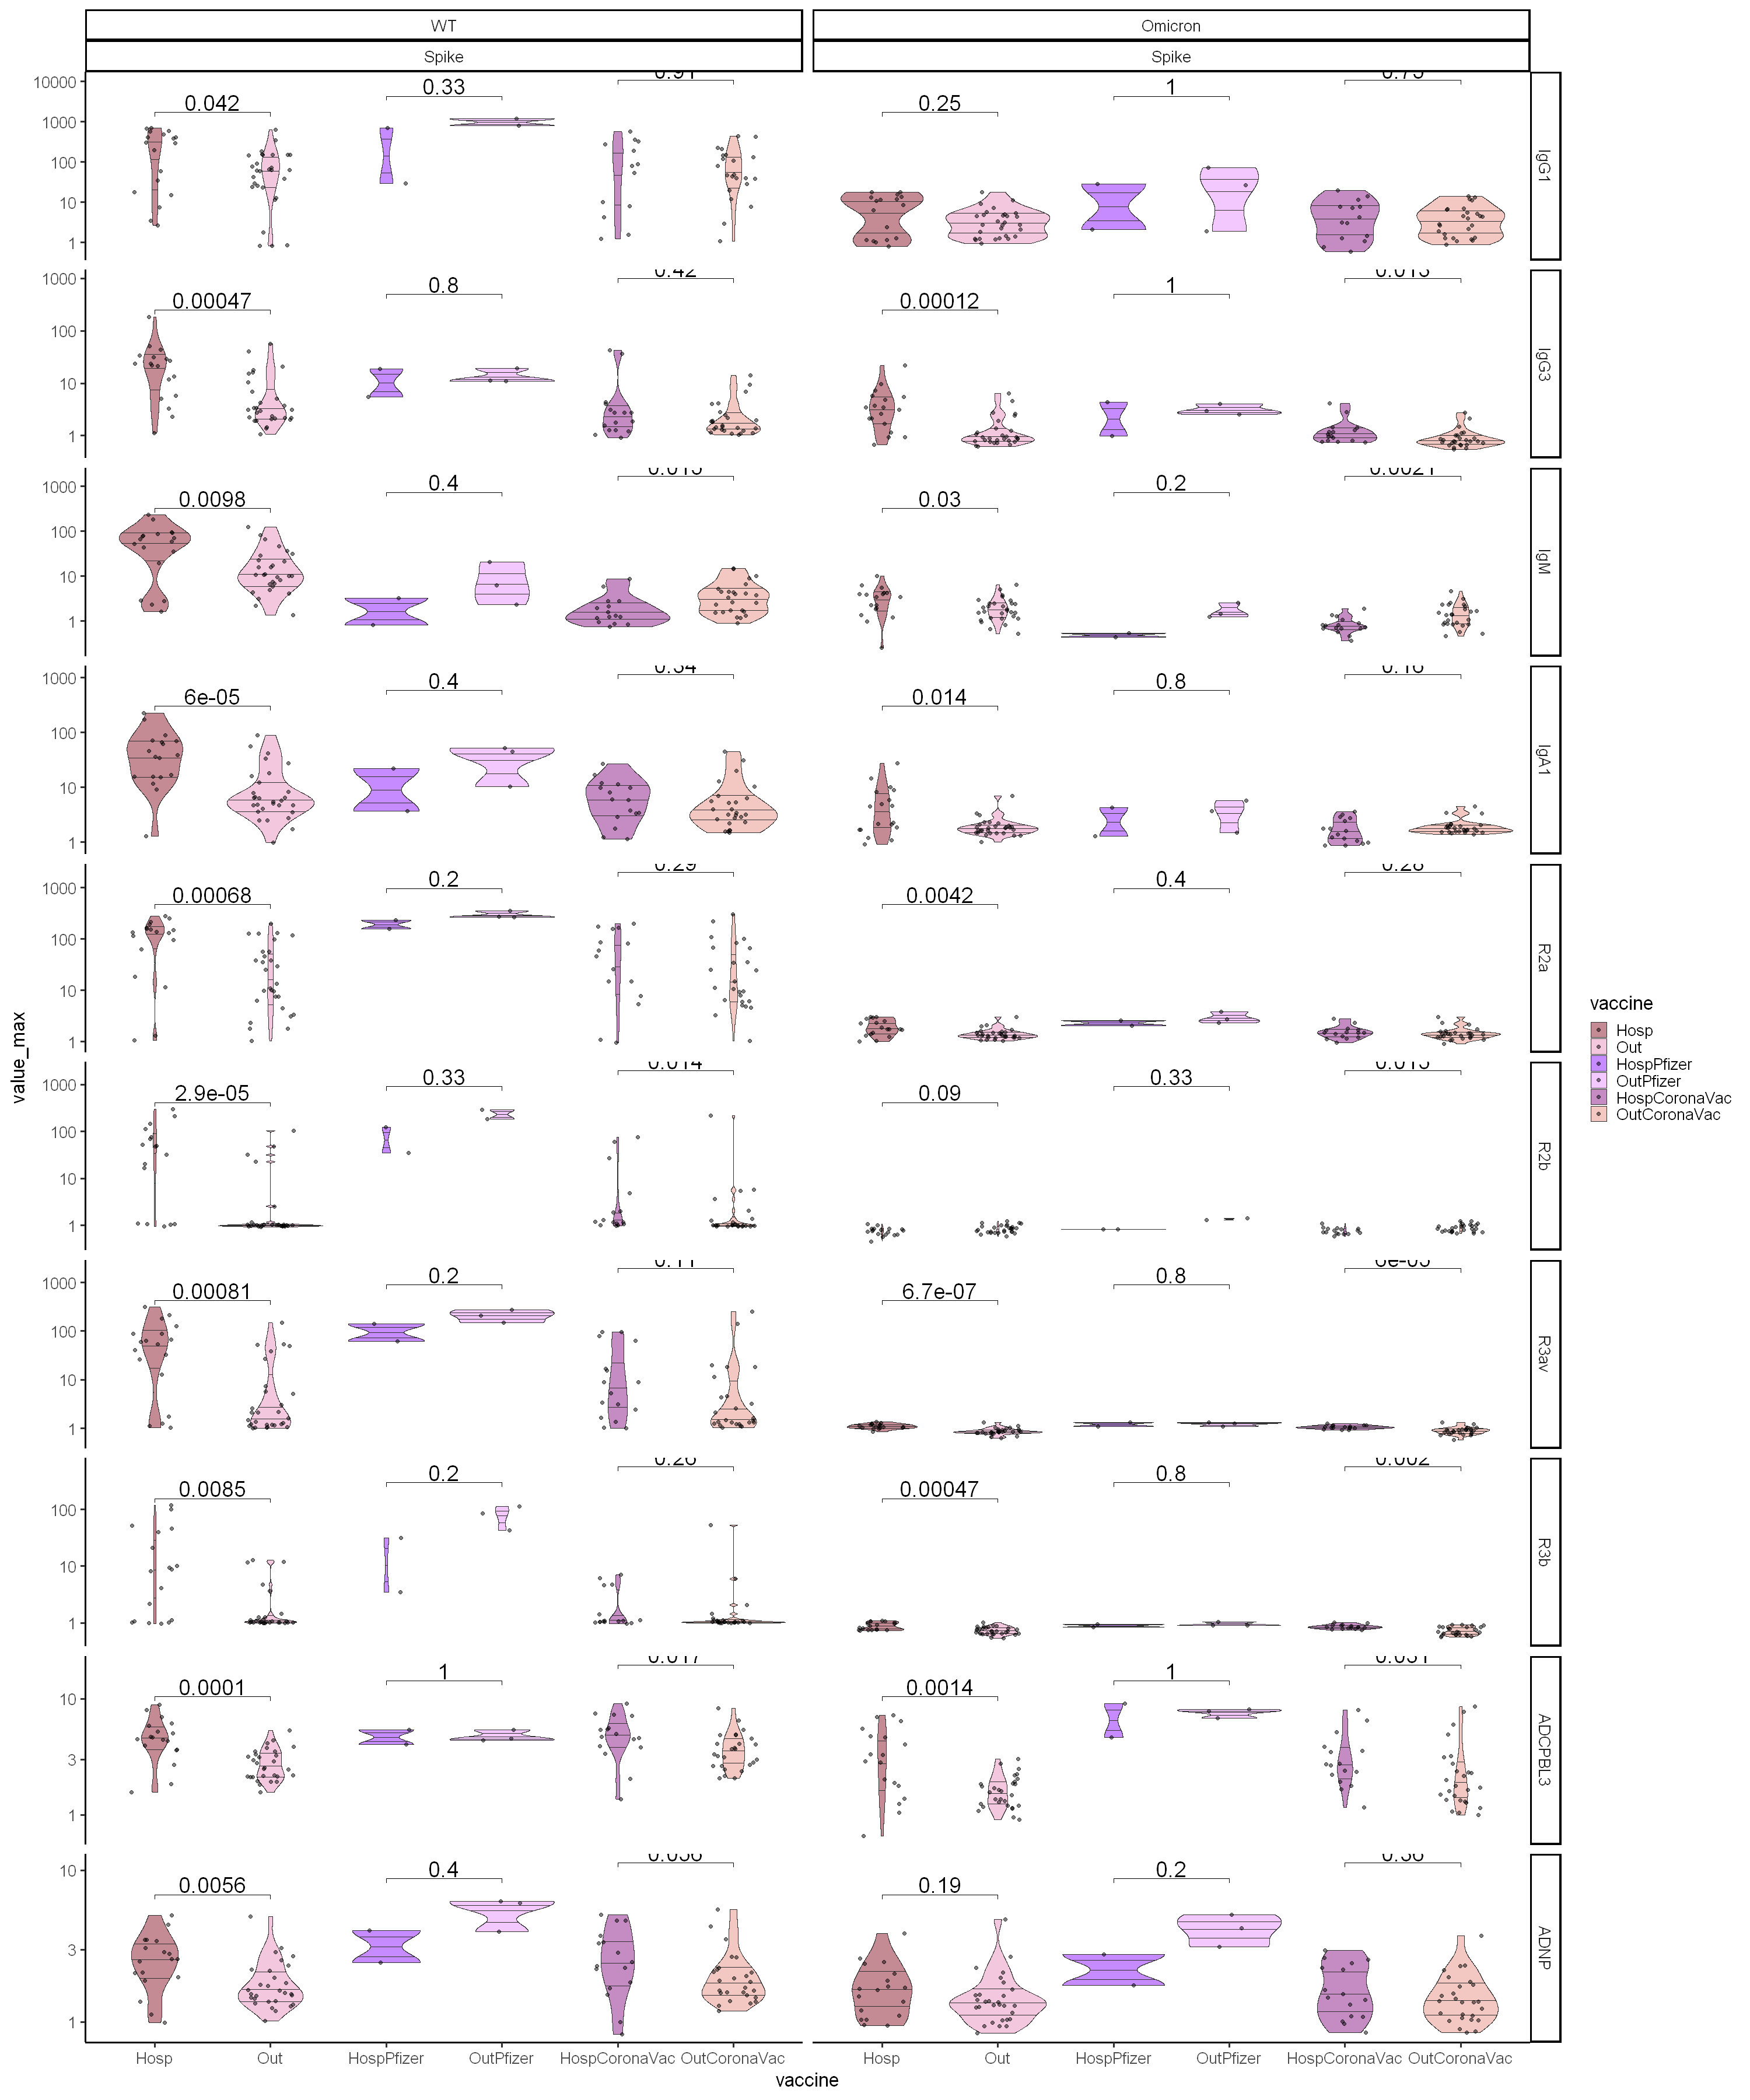

Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message:
"Removed 47 rows containing non-finite outside the scale range (`stat_ydensity()`)."
Warning message:
"Removed 47 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message in wilcox.test.default(c(1.3297327246646, 1.89452699384511, 1.17018820244101, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(0.0117170700628599, NA, 0.000891365186061027, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(0.0656393688469914, 1.78053998076429, 0.11546725633253, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(-0.01105631168164, 0.0511881966752081, :
"cannot compute exact p-value with ties"
Warning message:
"Removed 47 rows containing missing values or values outsid

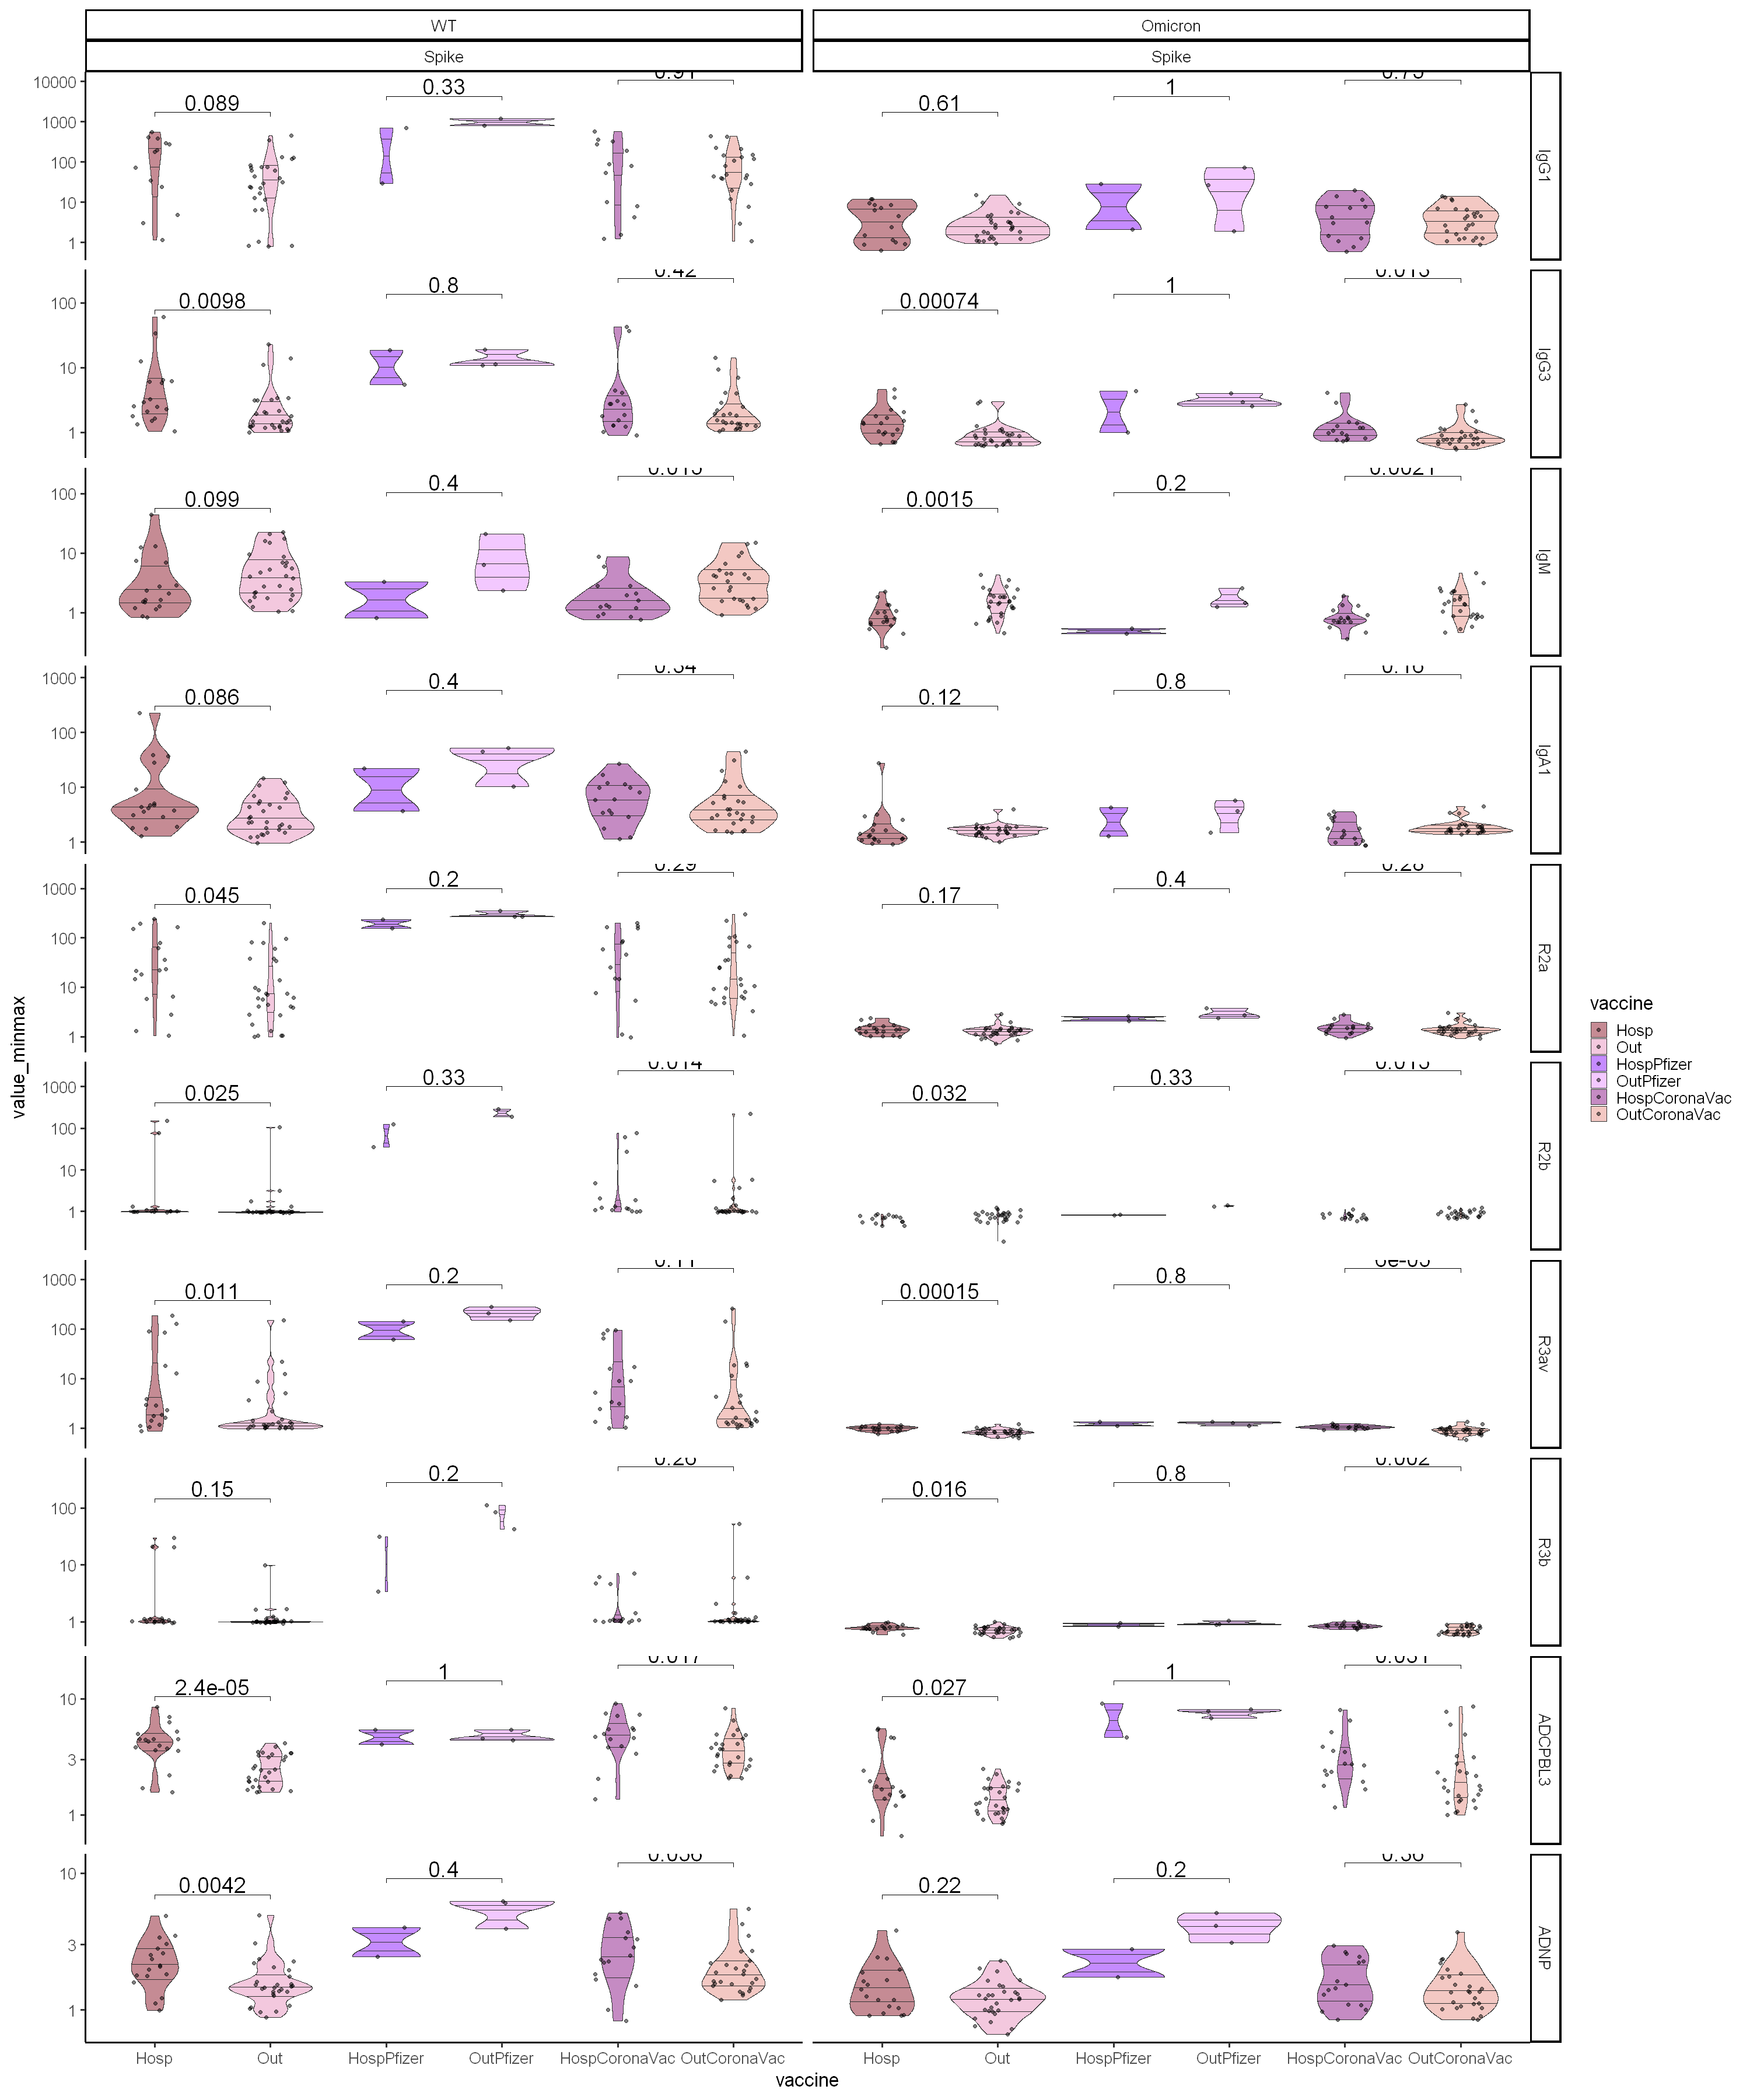

In [13]:
col = c('Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD',
           'HospCoronaVac'='#8B1888','OutCoronaVac'='#E79188',
           'HospPfizer'='#8B18FF','OutPfizer'='#E791FF')


options(repr.plot.width=25, repr.plot.height=30)

tmp_d %>% #filter(grepl('^I',affinity)) %>% 
    ggplot(aes(x=vaccine,y=value_max,fill=vaccine))+
        geom_violin(draw_quantiles = c(.25,.5,.75),alpha=0.5)+
        geom_jitter(alpha=.5,width = .2)+
        facet_grid(affinity~virus+antigen,scale='free_y')+
        scale_y_log10()+
        scale_fill_manual(values=col)+
        stat_compare_means(#aes(label = ..p.signif..),
                           hide.ns = T,size=8,
                           #method='t.test',
                           comparisons=comparisons)+
        # theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        theme_classic(base_size = 20)
ggsave(filename='../results/07_max_response.violin.pdf',height=30,width=25)
ggsave(filename='../results/figS6a.pdf',height=30,width=25)


##########################################################



tmp_d %>% #filter(grepl('^I',affinity)) %>% 
    ggplot(aes(x=vaccine,y=value_minmax,fill=vaccine))+
        geom_violin(draw_quantiles = c(.25,.5,.75),alpha=0.5)+
        geom_jitter(alpha=.5,width = .2)+
        facet_grid(affinity~virus+antigen,scale='free_y')+
        scale_y_log10()+
        scale_fill_manual(values=col)+
        stat_compare_means(#aes(label = ..p.signif..),
            hide.ns = T,size=8,
                           #method='t.test',
                           comparisons=comparisons)+
        # theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        theme_classic(base_size = 20)
ggsave(filename='../results/07_minmax_response.violin.pdf',height=30,width=25)
ggsave(filename='../results/figS6b.pdf',height=30,width=25)


Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message:
"Removed 30 rows containing non-finite outside the scale range (`stat_ydensity()`)."
Warning message:
"Removed 30 rows containing non-finite outside the scale range (`stat_signif()`)."
Warning message in wilcox.test.default(c(1.3297327246646, 1.89452699384511, 1.17018820244101, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(0.0117170700628599, NA, 0.000891365186061027, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(0.0656393688469914, 1.78053998076429, 0.11546725633253, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(c(-0.01105631168164, 0.0511881966752081, :
"cannot compute exact p-value with ties"
Warning message:
"Removed 30 rows containing missing values or values outsid

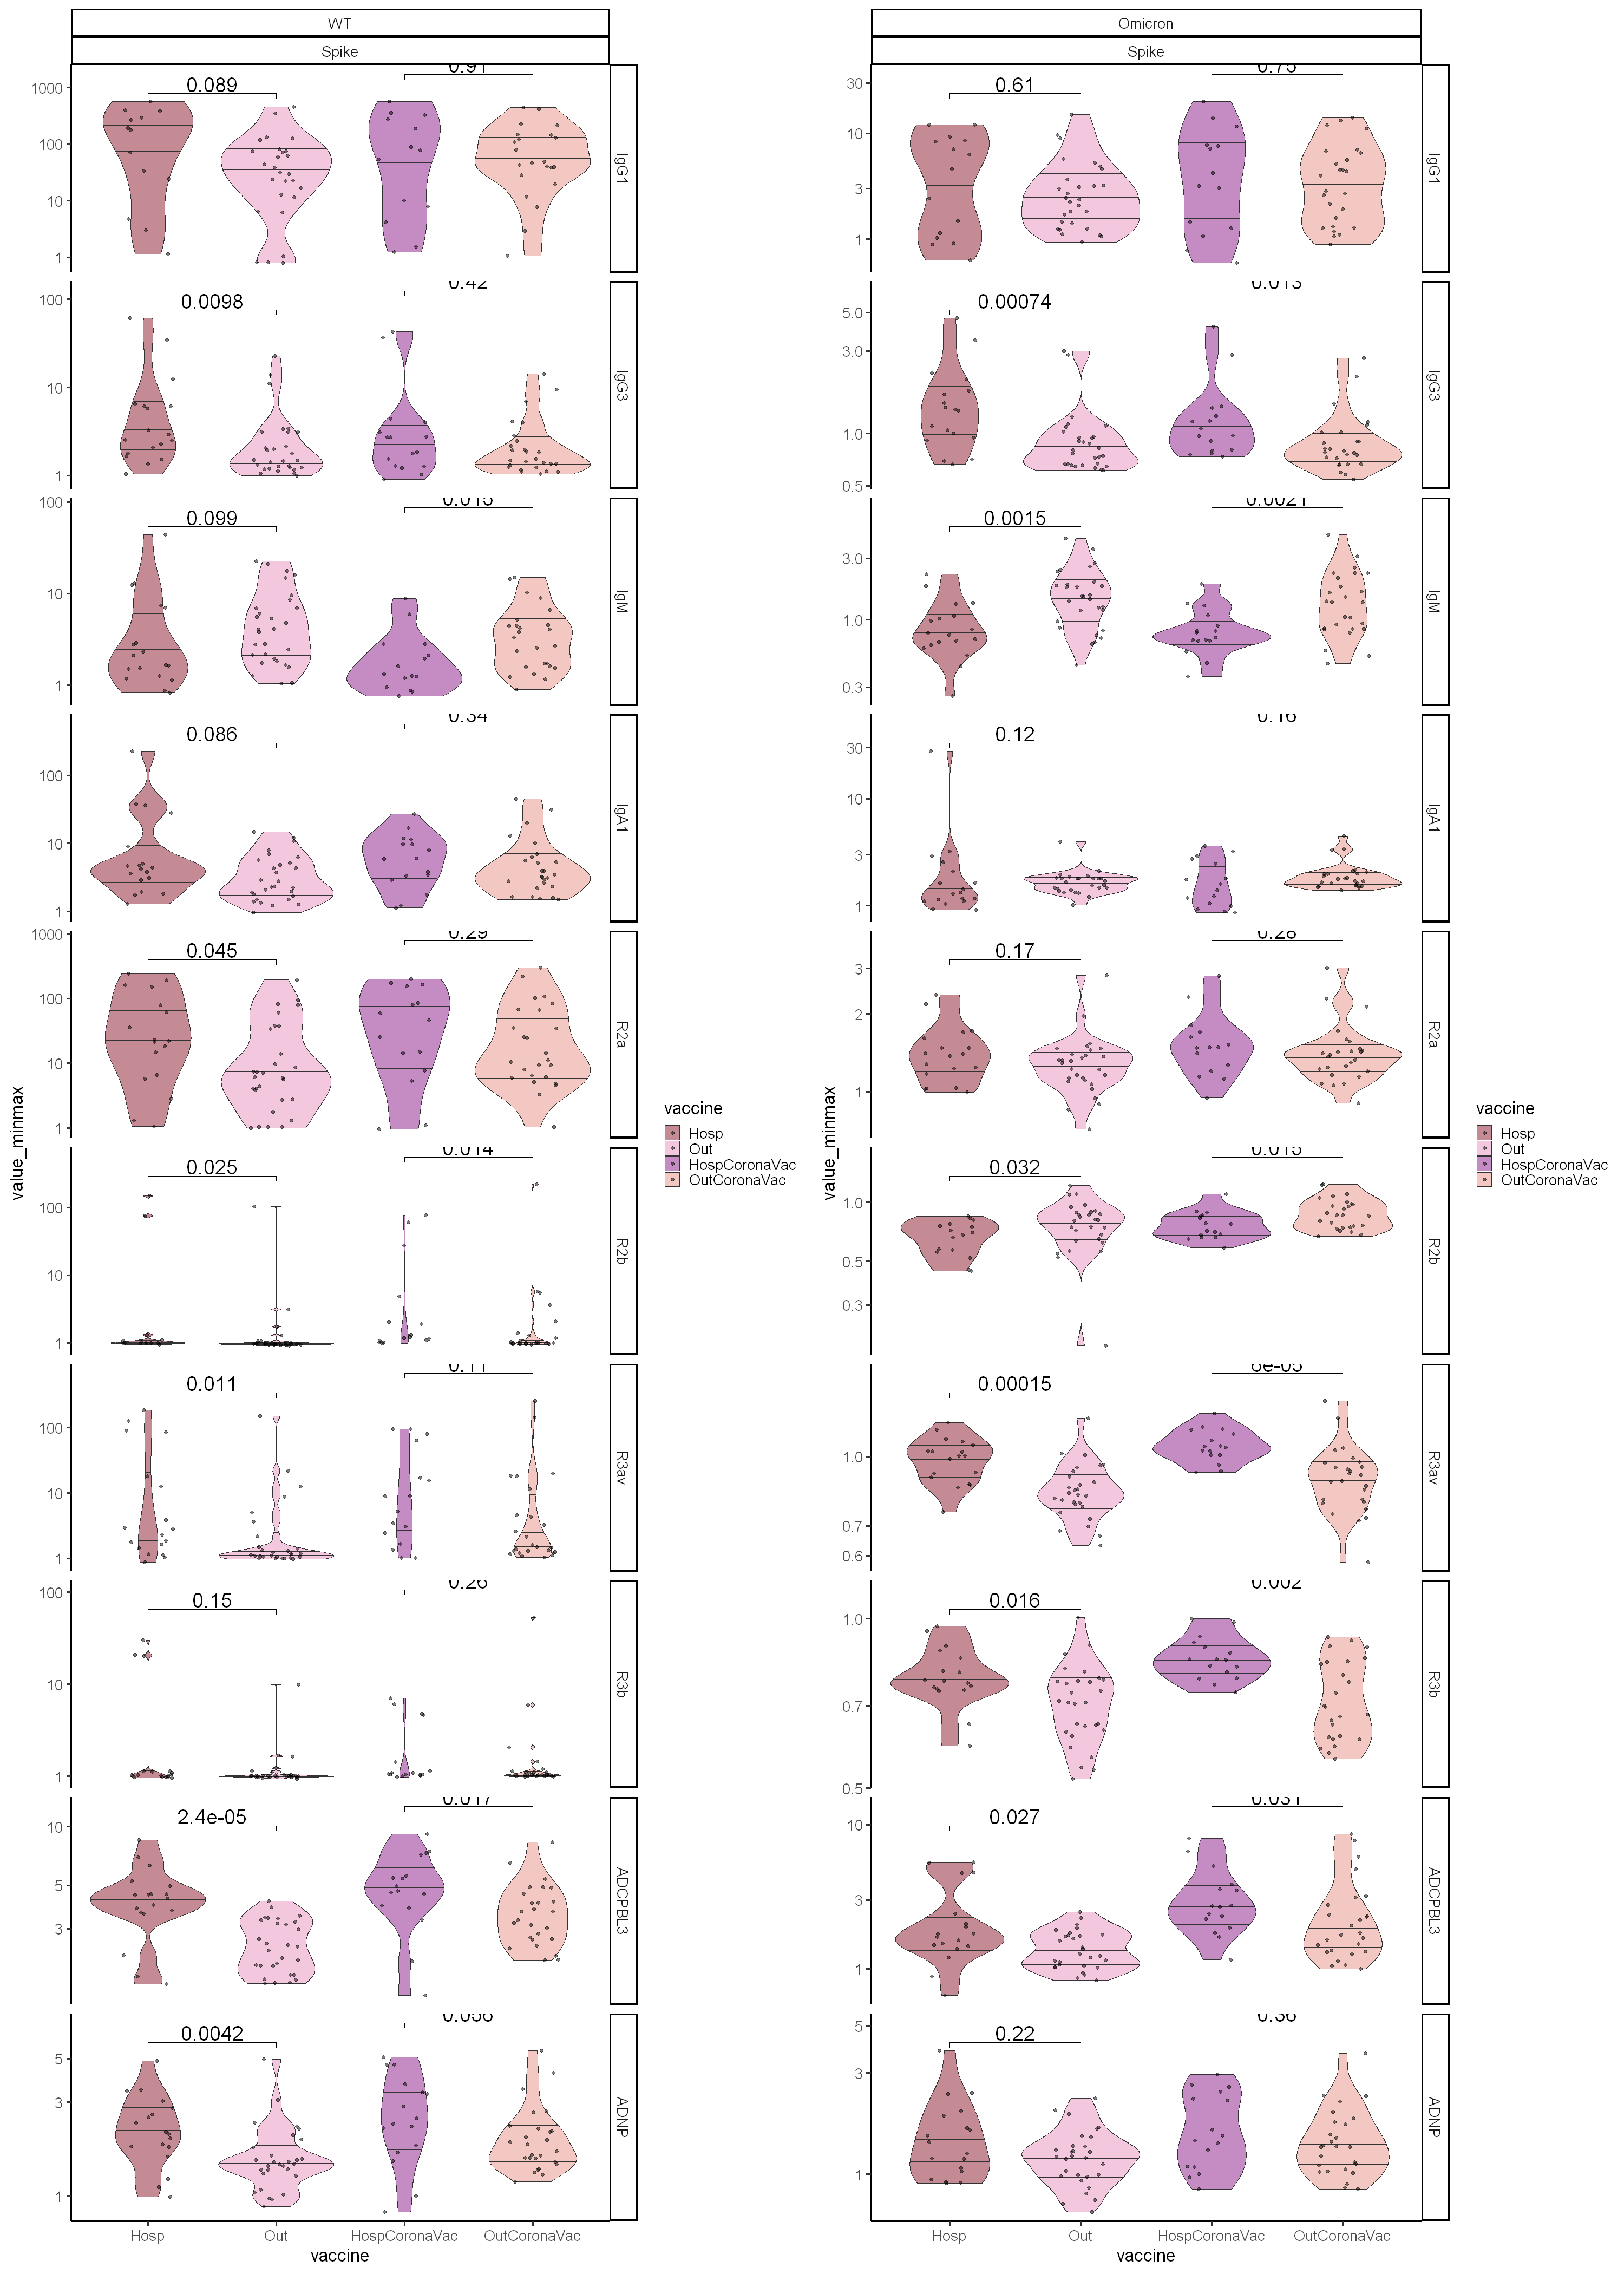

In [59]:
comparisons = list(c('Hosp','Out'),c('HospCoronaVac','OutCoronaVac'))


g1=tmp_d %>% filter(!grepl('Pfizer$',vaccine)&virus=='WT') %>% 
    ggplot(aes(x=vaccine,y=value_minmax,fill=vaccine))+
        geom_violin(draw_quantiles = c(.25,.5,.75),alpha=0.5)+
        geom_jitter(alpha=.5,width = .2)+facet_grid(affinity~virus+antigen,scale='free_y')+
        scale_y_log10()+scale_fill_manual(values=col)+
        stat_compare_means(hide.ns = T,size=8,comparisons=comparisons)+
        theme_classic(base_size = 20)
g2=tmp_d %>% filter(!grepl('Pfizer$',vaccine)&virus=='Omicron') %>% 
    ggplot(aes(x=vaccine,y=value_minmax,fill=vaccine))+
        geom_violin(draw_quantiles = c(.25,.5,.75),alpha=0.5)+
        geom_jitter(alpha=.5,width = .2)+facet_grid(affinity~virus+antigen,scale='free_y')+
        scale_y_log10()+scale_fill_manual(values=col)+
        stat_compare_means(hide.ns = T,size=8,comparisons=comparisons)+
        theme_classic(base_size = 20)
cowplot::plot_grid(g1,g2,nrow=1)
# ggsave(filename='../results/07_minmax_response.violin.pdf',height=30,width=25)
ggsave(filename='../results/fig4e.pdf',height=30,width=25)


Lab.ID,vaccine,antigen,affinity,virus,variable,group,value_minmax,naive_97.5,value_max,vaccine2,group_i
<chr>,<fct>,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
op1 2020 G4,Out,Spike,ADCPBL3,WT,WT.Spike.ADCPBL3,o,4.1509193,2.262951,4.150919,OutCoronaVac,
op1 2020 G4,Out,Spike,ADCPBL3,Omicron,Omicron.Spike.ADCPBL3,o,1.3709370,1.807072,1.631827,OutCoronaVac,
op1 2020 G4,Out,Spike,ADNP,WT,WT.Spike.ADNP,o,1.5219214,1.556405,1.806222,OutCoronaVac,
op1 2020 G4,Out,Spike,ADNP,Omicron,Omicron.Spike.ADNP,o,0.9785021,1.444991,1.149534,OutCoronaVac,
op1 2020 G4,Out,Spike,IgA1,WT,WT.Spike.IgA1,o,2.2944768,1.172578,5.409867,OutCoronaVac,
op1 2020 G4,Out,Spike,IgA1,Omicron,Omicron.Spike.IgA1,o,1.4014222,2.572024,1.951002,OutCoronaVac,


`summarise()` has grouped output by 'vaccine', 'vaccine2', 'antigen', 'affinity', 'virus'. You can override using the
`.groups` argument.
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"
Warning message in max(id

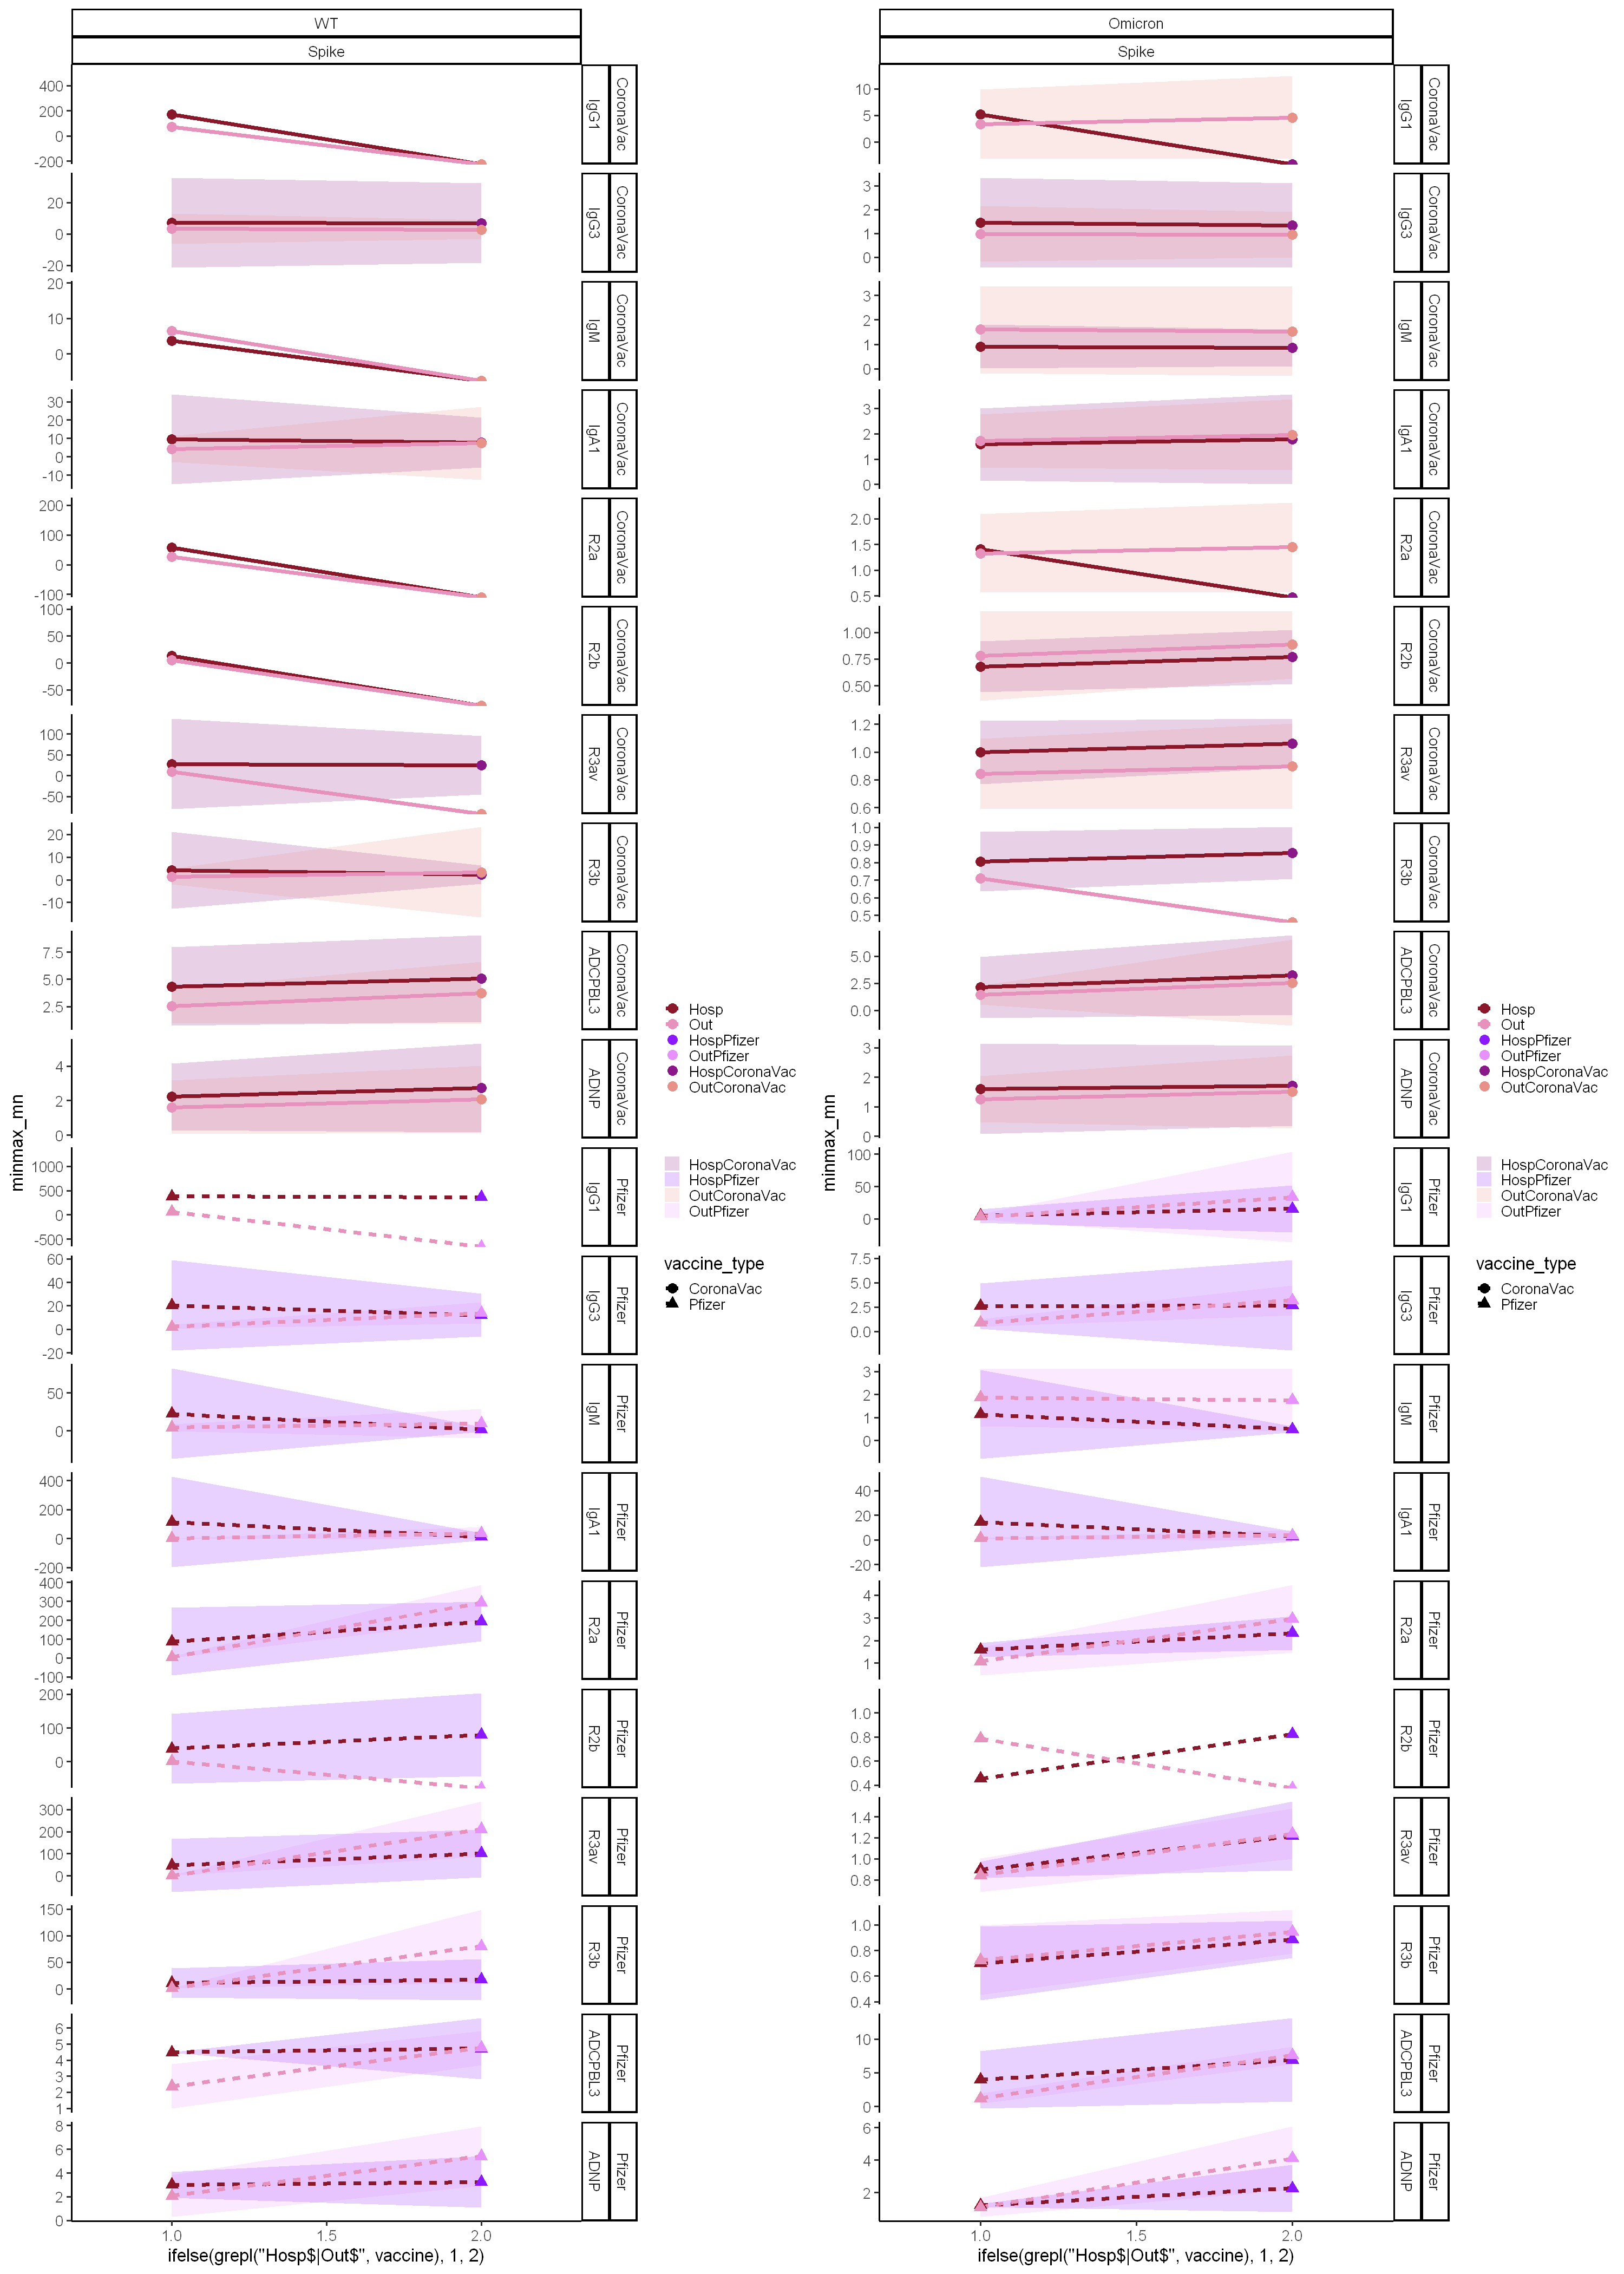

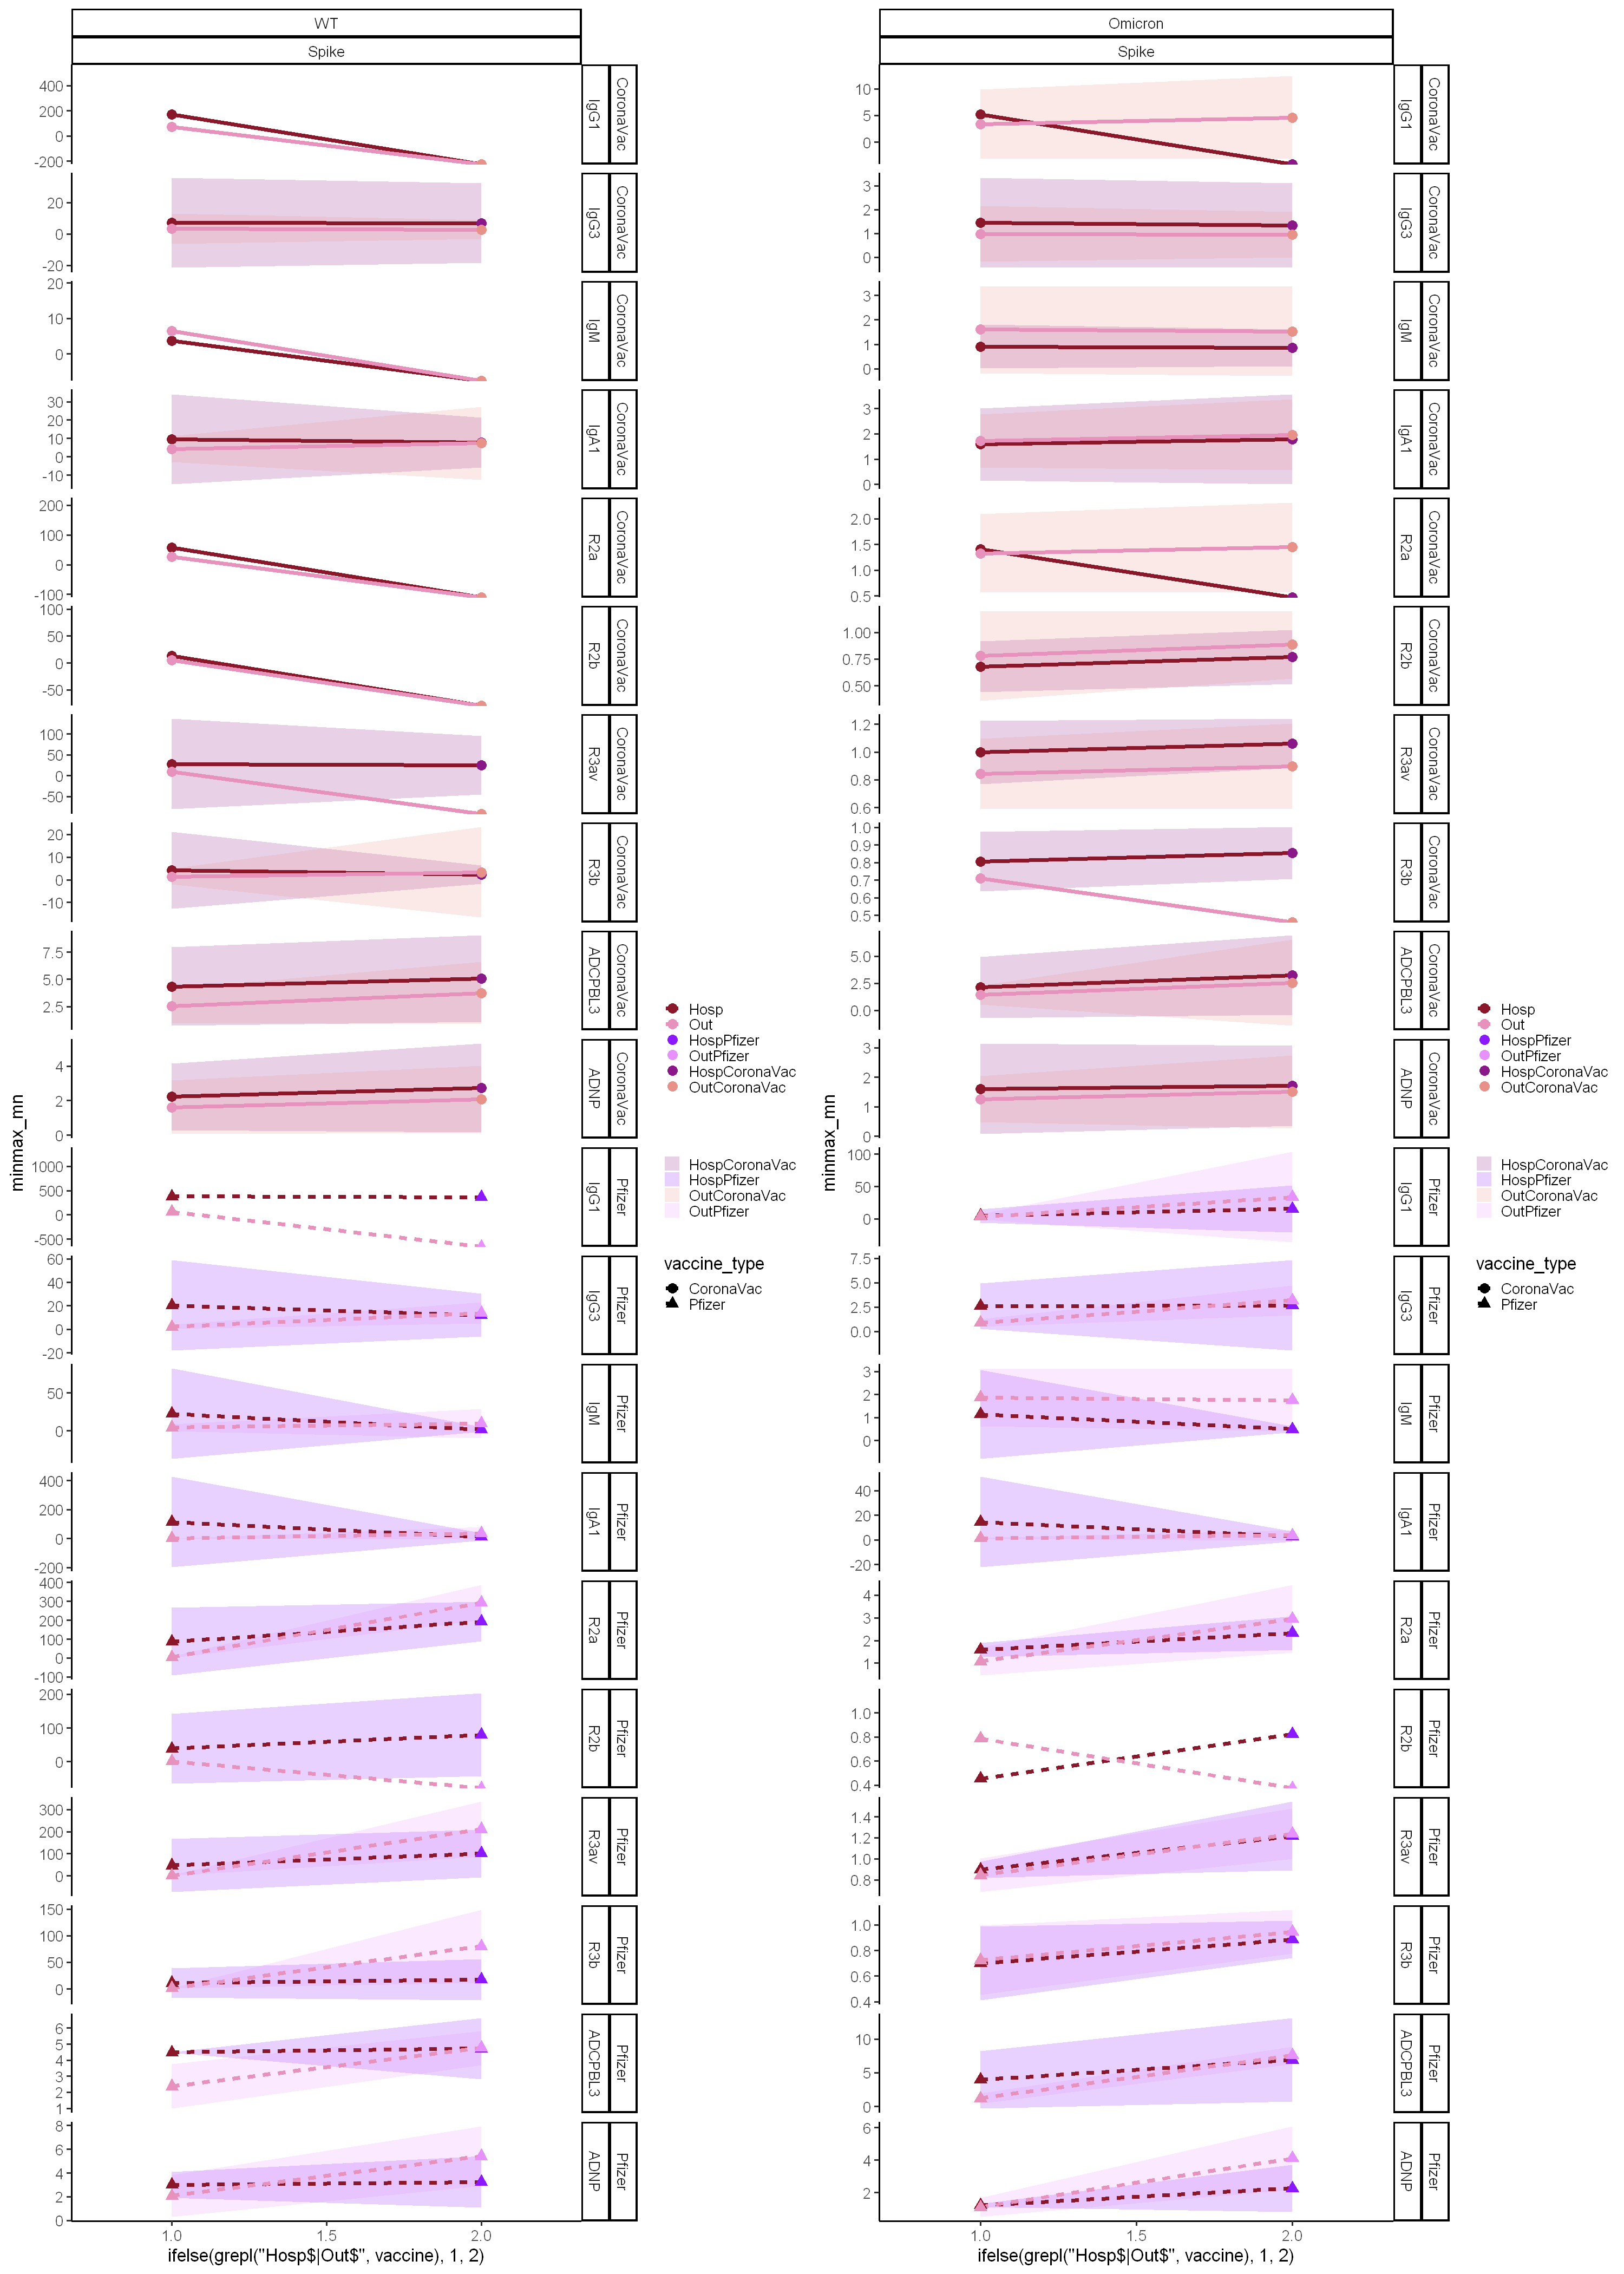

In [58]:
head(tmp_d)

col = c('Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD',
           'HospCoronaVac'='#8B1888','OutCoronaVac'='#E79188',
           'HospPfizer'='#8B18FF','OutPfizer'='#E791FF')

tmp_d2=tmp_d %>% group_by(vaccine,vaccine2,antigen,affinity,virus,variable) %>%
    summarize( 
        max_md = median(value_max,na.rm=T),
        max_mn = mean(value_max,na.rm=T),        
        max_SE = sd(value_max,na.rm=T), # sqrt(var(value_max,na.rm=T) / length(value_max)),
        minmax_md = median(value_minmax,na.rm=T),
        minmax_mn = mean(value_minmax,na.rm=T),        
        minmax_SE = sd(value_minmax,na.rm=T), #sqrt(var(value_minmax,na.rm=T) / length(value_minmax)),
        naive_97.5 = unique(naive_97.5)
    ) %>%
    mutate(
        infection_type=gsub('CoronaVac|Pfizer','',vaccine),
        # vaccine_type=gsub('Hosp|Out','',vaccine)
        vaccine_type=gsub('Hosp|Out','',vaccine2)
    )

# tmp_cp = tmp_d2[tmp_d2$vaccine_type=='',]
# tmp_d2$vaccine_type[tmp_d2$vaccine_type==''] = 'Pfizer'
# tmp_cp$vaccine_type[tmp_cp$vaccine_type==''] = 'CoronaVac'
# tmp_d2 = rbind(tmp_d2,tmp_cp)

options(repr.plot.width=25, repr.plot.height=35)

# tmp_d2 %>% filter( affinity=='IgG1' & virus=='WT' & antigen=='Spike' & vaccine_type=='CoronaVac')

### max mean
g1=ggplot(tmp_d2,aes( x=ifelse(grepl('Hosp$|Out$',vaccine),1,2),y=max_mn))+
    geom_ribbon(aes(ymin=max_mn-max_SE*1.96, ymax=max_mn+max_SE*1.96,fill=paste0(infection_type,vaccine_type)),alpha=.2 )+ #, alpha = 0.3)+
    geom_line(aes(color=infection_type,lty=vaccine_type),size=2)+geom_point(aes(shape=vaccine_type,color=vaccine),size=5)+
    scale_color_manual("",values=col)+scale_fill_manual("",values=col)+
    theme_classic(base_size=20)+xlim(0.75,2.25)+facet_grid(vaccine_type+affinity~virus+antigen,scale='free')

### minmax_mean (used in the paper)
g2a=ggplot(tmp_d2%>%filter(virus=='WT'),aes( x=ifelse(grepl('Hosp$|Out$',vaccine),1,2),y=minmax_mn))+
    geom_ribbon(aes(ymin=minmax_mn-minmax_SE*1.96, ymax=minmax_mn+minmax_SE*1.96,fill=paste0(infection_type,vaccine_type)),alpha=.2 )+ #, alpha = 0.3)+
    geom_line(aes(color=infection_type,lty=vaccine_type),size=2)+geom_point(aes(shape=vaccine_type,color=vaccine),size=5)+
    scale_color_manual("",values=col)+scale_fill_manual("",values=col)+
    theme_classic(base_size=20) +xlim(0.75,2.25)+facet_grid(vaccine_type+affinity~virus+antigen,scale='free')

g2b=ggplot(tmp_d2%>%filter(virus=='Omicron'),aes( x=ifelse(grepl('Hosp$|Out$',vaccine),1,2),y=minmax_mn))+
    geom_ribbon(aes(ymin=minmax_mn-minmax_SE*1.96, ymax=minmax_mn+minmax_SE*1.96,fill=paste0(infection_type,vaccine_type)),alpha=.2 )+ #, alpha = 0.3)+
    geom_line(aes(color=infection_type,lty=vaccine_type),size=2)+geom_point(aes(shape=vaccine_type,color=vaccine),size=5)+
    scale_color_manual("",values=col)+scale_fill_manual("",values=col)+
    theme_classic(base_size=20) +xlim(0.75,2.25)+facet_grid(vaccine_type+affinity~virus+antigen,scale='free')
g2=cowplot::plot_grid(g2a,g2b,nrow=1)

# cowplot::plot_grid(g1,g2)
ggsave(g1,filename='../results/07_max_response.trend.max.pdf',height=35,width=12.5)
ggsave(g2,filename='../results/07_max_response.trend.minmax.pdf',height=35,width=12.5)
print(g2)
# ggsave(g2,filename='../results/fig4e.pdf',height=35,width=12.5)

# cowplot::plot_grid(
#     g1 + scale_y_continuous(lim=c(-1,5)),
#     g2 + scale_y_continuous(lim=c(-1,5))
#     )
# ggsave(filename='../results/07_max_response.trend.low.pdf',height=35,width=25)

ggsave(g1 + scale_y_continuous(lim=c(-1,5)),filename='../results/07_max_response.trend.low.max.pdf',height=35,width=12.5)
ggsave(g2 + scale_y_continuous(lim=c(-1,5)),filename='../results/07_max_response.trend.low.minmax.pdf',height=35,width=12.5)
# ggsave(g2 + scale_y_continuous(lim=c(-1,5)),filename='../results/fig4e_alt.pdf',height=35,width=12.5)
g2 + scale_y_continuous(lim=c(-1,5))


In [24]:
# head(tmp_d2)

In [16]:
# with( unique( tmp_d2[,c('Lab.ID','vaccine2')]) , table(vaccine2))

In [17]:
table( unique(tmp_d2[,c('vaccine2','variable')])$vaccine2)


HospCoronaVac    HospPfizer  OutCoronaVac     OutPfizer 
           20            20            20            20 

In [25]:
tmp_d2

group_i,vaccine2,vaccine,antigen,affinity,virus,variable,max_md,max_mn,max_SE,minmax_md,minmax_mn,minmax_SE,naive_97.5,infection_type,vaccine_type
<chr>,<chr>,<fct>,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
,HospCoronaVac,Hosp,Spike,IgG1,WT,WT.Spike.IgG1,297.7213999,297.7279827,64.61263812,124.3021050,170.3319201,45.75328199,9.138638,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgG1,Omicron,Omicron.Spike.IgG1,8.4698314,-Inf,NaN,4.5757815,5.2035988,1.07748280,1.556199,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgG3,WT,WT.Spike.IgG3,21.5422657,29.2690173,10.95083806,2.5214286,7.1600034,3.66157781,1.435068,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgG3,Omicron,Omicron.Spike.IgG3,2.8852993,4.5227634,1.30815038,1.2286461,1.4579860,0.24090488,1.148686,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgM,WT,WT.Spike.IgM,68.0634025,68.6362280,16.21218768,1.8675090,3.7602155,0.99856568,1.972347,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgM,Omicron,Omicron.Spike.IgM,3.6134980,3.5049024,0.61529332,0.7760344,0.9053754,0.11457494,4.100701,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgA1,WT,WT.Spike.IgA1,36.2714058,46.0925357,10.87284421,4.2709201,9.5744735,3.13079577,1.172578,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,IgA1,Omicron,Omicron.Spike.IgA1,2.2141130,4.5038648,1.00008038,1.2447669,1.5861970,0.18160750,2.572024,Hosp,CoronaVac
,HospCoronaVac,Hosp,Spike,R2a,WT,WT.Spike.R2a,132.4998861,123.0532486,21.81130908,21.3664674,57.8057653,19.38481886,1.426075,Hosp,CoronaVac
